In [1]:
import torch
from vit_pytorch import ViT
import torch.nn as nn
from model import MyViT
from torch.utils.data import DataLoader, random_split, Dataset

c:\Users\itayk\miniconda3\envs\Dcv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the seed for PyTorch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
import torch
from vit_pytorch import ViT

vit_model = MyViT(
    image_size = 28,
    patch_size = 4,
    num_classes = 1000,
    dim = 1028,
    depth = 6,
    heads = 6,
    mlp_dim = 1028 * 3,
    dropout = 0,
    # dropout = 0.1,
    emb_dropout = 0,
    # emb_dropout = 0.1,
    channels = 1
)

img = torch.randn(1, 1, 28, 28)

# preds = v(img) # (1, 1000)

16


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(vit_model)
print(f'Total number of parameters: {total_params}')


Total number of parameters: 48694324


In [5]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
# testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [6]:
import torch.utils
import torch.utils.data


train_size = 128
train_dataset, test_dataset = random_split(trainset, [train_size, len(trainset) - train_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:
sample_images = next(iter(trainloader))[0]
test_samples  = next(iter(test_loader))[0]

In [8]:
output = vit_model(sample_images)

In [9]:
output.shape

torch.Size([64, 1, 28, 28])

In [10]:
import matplotlib.pyplot as plt
import torch

def print_images(images):
    """
    Prints a batch of images with shape (64, 1, 28, 28).

    Parameters:
    images (torch.Tensor): A tensor of shape (64, 1, 28, 28) containing the images to be printed.
    """
    # Ensure the input is a 4D tensor
    assert images.ndim == 4, "Input tensor must be 4-dimensional"
    assert images.shape[1] == 1, "Input tensor must have a single channel"
    
    # Get the number of images in the batch
    batch_size = images.shape[0]
    
    # Define the number of rows and columns for the plot grid
    n_cols = 8
    n_rows = (batch_size + n_cols - 1) // n_cols
    
    # Create a figure to hold the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 1.5))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i in range(batch_size):
        # Get the image and remove the channel dimension
        img = images[i, 0, :, :].numpy()
        
        # Plot the image
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    
    # Remove any remaining empty subplots
    for i in range(batch_size, len(axes)):
        axes[i].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [11]:
# print_images(sample_images)
# with torch.no_grad():
#     print_images(output)

In [12]:
checkpoint_path = './bit9/epoch_27700_model_0.00000467.pth'
import os
if not os.path.isfile(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint file '{checkpoint_path}' not found")

In [13]:
vit_model.load_state_dict(torch.load(checkpoint_path))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')


In [18]:
import torch.optim as optim
import torch
from tqdm import tqdm
import time

# Check if GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Define loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(vit_model.parameters(), lr=0.001)
# milestones = [3000, 6000, 8000, 1000, 12000, 14000, 17000]

optimizer = optim.Adam(vit_model.parameters(), lr=0.0000014)

# Define the learning rate scheduler
milestones = [150000]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

# Move the model to the GPU
vit_model.to(device)

num_epochs = 160_000

# Training loop
def train_model(model, optimizer, scheduler, dataloader, target_loss=1e-8):
    model.train()
    with tqdm(total=num_epochs, desc="Processing") as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, _ in dataloader:
                # Move the images to the GPU
                images = images.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(dataloader)
            pbar.set_postfix({'Loss:': f'{avg_loss}'})
            pbar.update(1)

            # Step the scheduler
            # scheduler.step()
            # if epoch % 400 == 0 and epoch != 0:
            #     time.sleep(90)

            if epoch % 150 == 0 and epoch != 0:
                torch.save(model.state_dict(), f'./bit10/epoch_{epoch}_model_{avg_loss:.8f}.pth')

            # Save intermediate models
            if avg_loss <= target_loss:
                torch.save(model.state_dict(), f'./bit10/model_{avg_loss:.8f}.pth')
                break

# Train the model
train_model(vit_model, optimizer, scheduler, train_loader)


Processing:   9%|▉         | 15179/160000 [1:34:49<15:04:38,  2.67it/s, Loss:=3.009861984537565e-06] 


KeyboardInterrupt: 

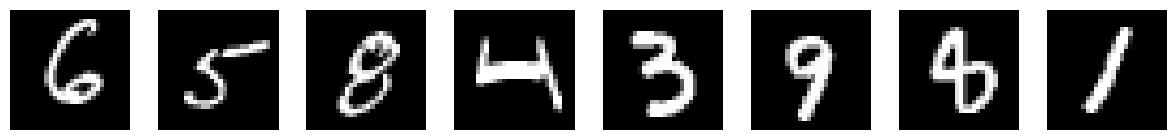

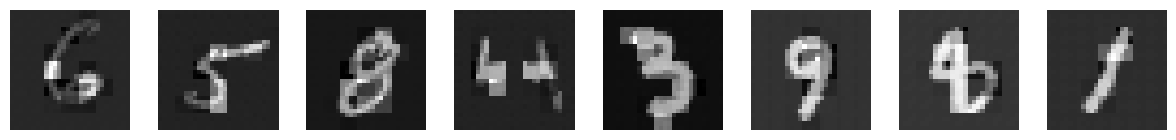

In [19]:
print_images(sample_images[:8,:,:])
with torch.no_grad():
    print_images(vit_model(sample_images[:8,:,:].to(device)).cpu())

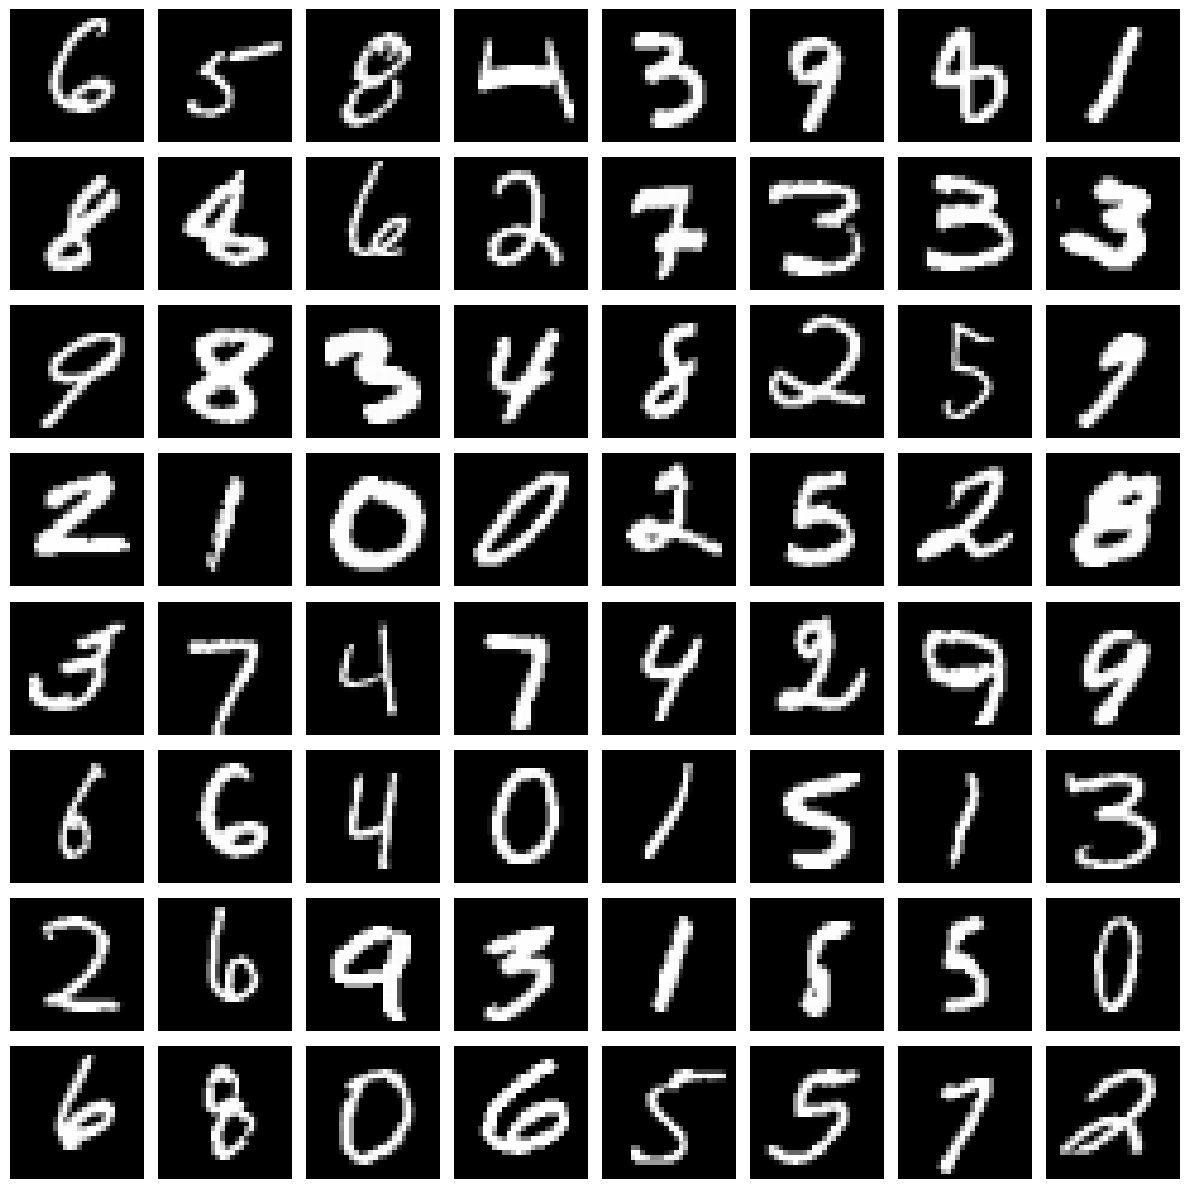

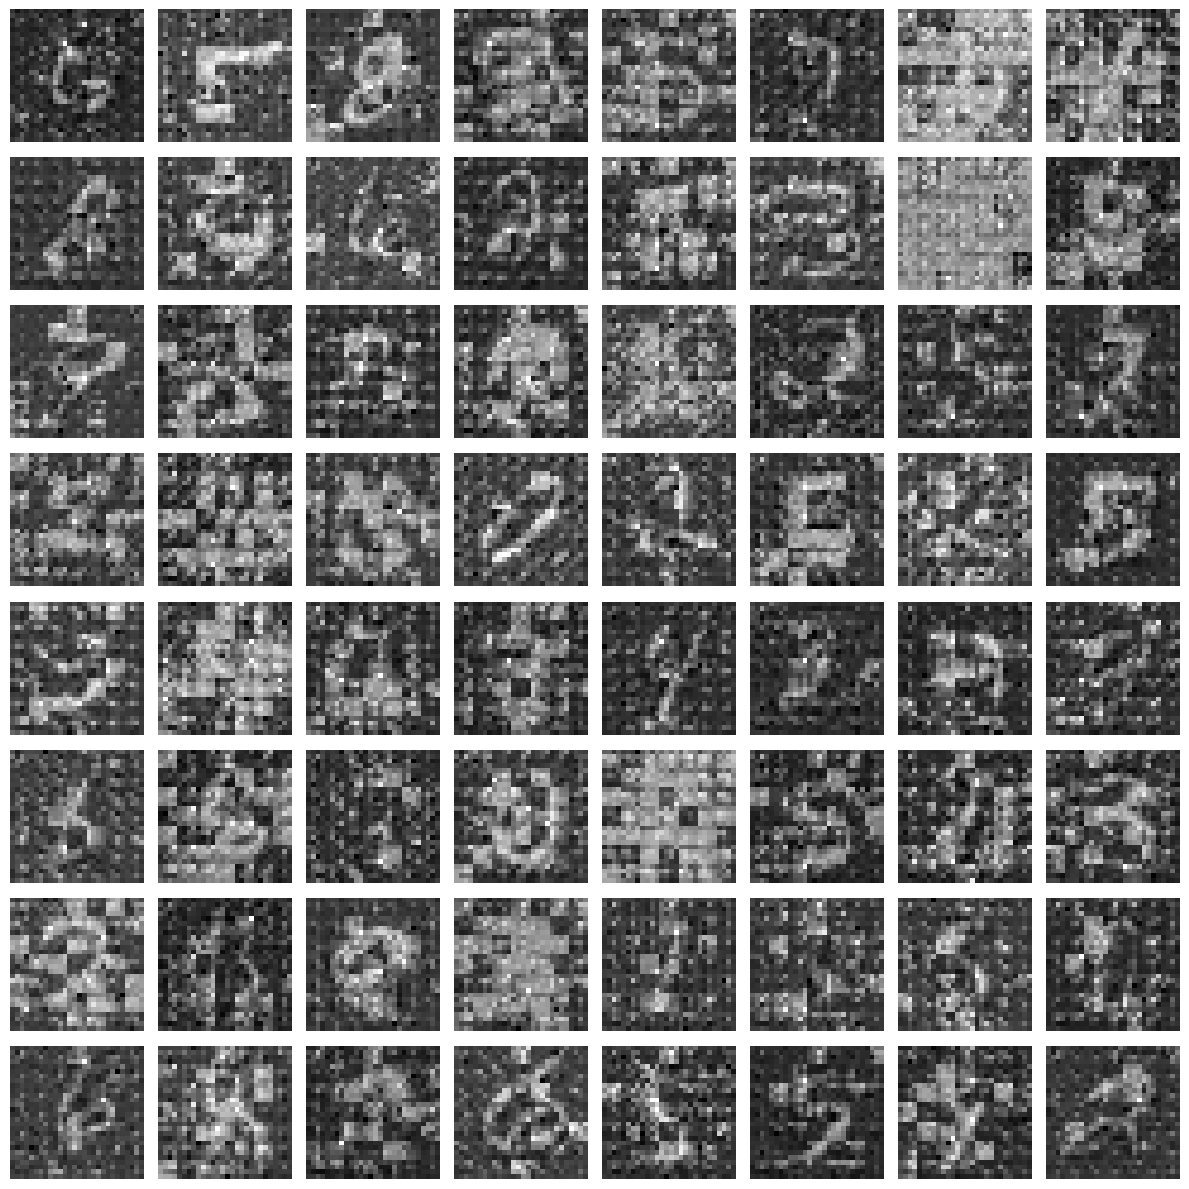

In [26]:
print_images(sample_images[:,:,:])
with torch.no_grad():
    samples = vit_model(sample_images[:,:,:].to(device)).cpu()
    for i in range(20):
        samples = vit_model(samples.to(device)).cpu()
    print_images(samples)

In [ ]:
vit_model(sample_images[:6,:,:].to(device))

tensor([[[[-1.0019, -1.0061, -0.9998,  ..., -1.0066, -1.0004, -1.0001],
          [-0.9964, -1.0025, -1.0057,  ..., -1.0034, -1.0058, -1.0017],
          [-1.0070, -1.0015, -0.9941,  ..., -1.0015, -0.9957, -1.0016],
          ...,
          [-0.9955, -1.0029, -1.0061,  ..., -1.0025, -1.0056, -1.0007],
          [-1.0067, -1.0012, -0.9946,  ..., -1.0009, -0.9943, -1.0026],
          [-1.0054, -0.9966, -0.9978,  ..., -0.9961, -0.9967, -0.9984]]],


        [[[-0.9992, -0.9921, -0.9941,  ..., -0.9972, -0.9972, -0.9944],
          [-1.0175, -0.9992, -1.0089,  ..., -1.0051, -1.0035, -0.9971],
          [-0.9927, -1.0042, -0.9990,  ..., -0.9993, -1.0030, -1.0051],
          ...,
          [-1.0120, -1.0017, -1.0050,  ..., -0.9988, -1.0079, -0.9935],
          [-0.9917, -1.0018, -0.9989,  ..., -1.0020, -1.0005, -1.0066],
          [-0.9905, -1.0048, -1.0027,  ..., -1.0023, -0.9986, -0.9993]]],


        [[[-0.9960, -0.9946, -0.9964,  ..., -0.9978, -0.9986, -0.9960],
          [-1.0021, -1.004

In [ ]:
sample = sample_images[-1:,:,:]
print_images(sample)
for i in range(400):
    with torch.no_grad():
        sample = vit_model(sample.to(device)).cpu()
    print_images(sample)

In [ ]:
vit_model(sample_images[0:,:,:].to(device)).cpu()

tensor([[[[-0.9923, -1.0516, -1.0054,  ..., -1.0225, -1.0183, -1.0417],
          [-1.0289, -1.0257, -1.0128,  ..., -1.0009, -1.0455, -1.0055],
          [-1.0540, -1.0372, -1.0315,  ..., -1.0378, -1.0218, -1.0426],
          ...,
          [-0.9892, -0.9842, -1.0207,  ..., -1.0042, -0.9959, -1.0004],
          [-1.0069, -1.0215, -1.0342,  ..., -0.9934, -1.0698, -0.9955],
          [-0.9524, -1.0267, -1.0182,  ..., -1.0264, -1.0129, -1.0689]]],


        [[[-1.0186, -1.0049, -0.9692,  ..., -1.0130, -0.9817, -0.9786],
          [-1.0243, -0.9947, -1.0008,  ..., -0.9980, -1.0034, -0.9893],
          [-0.9740, -0.9886, -0.9901,  ..., -0.9829, -1.0036, -1.0032],
          ...,
          [-0.9622, -1.0254, -0.9906,  ..., -0.9463, -1.0058, -1.0224],
          [-1.0077, -1.0302, -1.0268,  ..., -1.0370, -0.9975, -1.0199],
          [-1.0316, -1.0033, -0.9936,  ..., -1.0175, -0.9850, -1.0080]]],


        [[[-1.0215, -1.0251, -1.0237,  ..., -1.0468, -1.0003, -1.0047],
          [-0.9877, -1.071